In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix;

In [2]:
df = pd.read_csv('./data/bank-additional-full.csv',sep=';')
df.head()
#changing the target variable to dummy
df['y'] = np.where(df['y']=='yes',1,0)

#looking into sample class balance
print(df.groupby('y')[['age']].count()/df['y'].count())
print(df.groupby('y')[['age']].count())
df.shape

        age
y          
0  0.887346
1  0.112654
     age
y       
0  36548
1   4640


(41188, 21)

In [3]:
#Modeling

#1. categorical variable to dummy

#1.1 assigning categorical variables to a list
categorical_features = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

#1.2 creating a copy of the original data frame and alias it with dummy
# this step is made to maintain a clean structure
dummy_df = df
print('number of columns in original data frame = ',dummy_df.shape[1])

#1.3 appending the dummy data frame with dummies for categorical features
for feat in categorical_features:
    cat_list = 'var_'+feat #adjust the name of feature
    cat_list = pd.get_dummies(df[feat],prefix=feat) #crack the feature open from the data feam and fill each component with dummies
    df_temp  = dummy_df.join(cat_list) #append cat_list to the existing data frame
    dummy_df = df_temp
print('number of columns in the dummy data frame = ',dummy_df.shape[1])

#1.4 drop the categorical features from the data frame because we, now, have their dummies
dummy_df = dummy_df.drop(categorical_features,axis=1)
print('number of columns in the cleaned dummy data frame = ',dummy_df.shape[1])

number of columns in original data frame =  21
number of columns in the dummy data frame =  74
number of columns in the cleaned dummy data frame =  64


In [4]:
#2. Train/Test split

#2.1 spliting dataframe columns to features and target
X = dummy_df.drop('y',axis=1)
y = dummy_df['y']

#2.2 train test split
# note that we maintained the unbalanced class within our train and test target
# we did this by stratifying y
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=123,stratify=y,test_size=0.25)

print('X training set: ',X_train.shape[0],'| X testing set: ',X_test.shape[0])
print('y training set: ',len(y_train),'| y testing set: ',len(y_test),'\n')
print('training the data on ',X_train.shape[0]/dummy_df.shape[0],'% of the sample \n')
print('Maintained the same class unbalance:')
y_test.value_counts()/y_test.shape[0]

X training set:  30891 | X testing set:  10297
y training set:  30891 | y testing set:  10297 

training the data on  0.75 % of the sample 

Maintained the same class unbalance:


0    0.887346
1    0.112654
Name: y, dtype: float64

In [5]:
#3. Balancing the Training set
# Syntheric Minority Over-sampling Technique

os = SMOTE(random_state=0)

os_X, os_y = os.fit_sample(X_train,y_train)


print('we increased the number of observations with a 1 outcome from 3,480 to 27,411 \n')
print(y_train.value_counts())
print(os_y.value_counts())

we increased the number of observations with a 1 outcome from 3,480 to 27,411 

0    27411
1     3480
Name: y, dtype: int64
1    27411
0    27411
Name: y, dtype: int64


C:\Users\gaummt\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy sorce:  0.868505389919394
auc:  0.8461275299747522


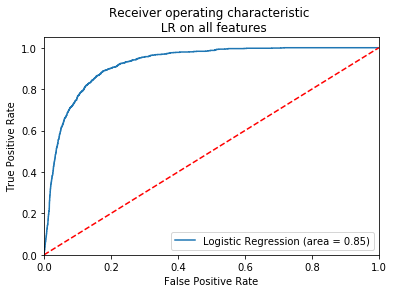

In [6]:
#4. Modeling
#4.1 Fitting a classification model to all features in the over-sampled data
#4.1.1 LR

#istantiate the model
lr_all_feat = LogisticRegression()

#fit the model
lr_all_feat.fit(os_X,os_y);

#using the model to predict
y_pred_lr_all_feat = lr_all_feat.predict(X_test)

#-----------------------------
#model performance
# compute Receiver operating characteristic (ROC)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_lr_all_feat)


print('accuracy sorce: ',lr_all_feat.score(X_test,y_test))
print('auc: ',metrics.auc(fpr, tpr));

#-----------------------------
#ROC:
logit_roc_auc = roc_auc_score(y_test, lr_all_feat.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lr_all_feat.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic \n LR on all features')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

accuracy sorce:  0.8885112168592794
auc:  0.7294543217610852


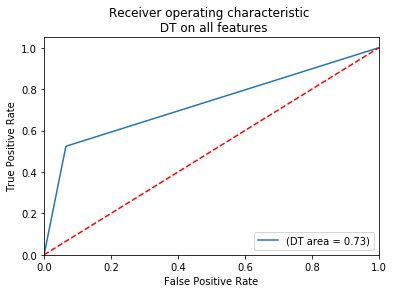

In [7]:
# 4.1.2 Fitting Decision Tree
#instantiate the model
dt_all_feat = DecisionTreeClassifier()
#fit the model
dt_all_feat.fit(os_X,os_y)
#prdict using the model
y_pred_dt_all_feat = dt_all_feat.predict(X_test)
#checking performance
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_dt_all_feat)

print('accuracy sorce: ',dt_all_feat.score(X_test,y_test))
print('auc: ',metrics.auc(fpr, tpr));

#-----------------------------
#ROC:
logit_roc_auc = roc_auc_score(y_test, dt_all_feat.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dt_all_feat.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='(DT area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic \n DT on all features')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

---
## Feature Elimination

In [8]:
#4.2 Eleminating features
features_list = os_X.columns

In [9]:
#4.2.1 generating a list of the most important n features

#we will use RFE to reduce the number of features
#as always, our test data is not touched
#we will use the training oversampled data
rfe_lr = LogisticRegression()
rfe = RFE(rfe_lr,35)
rfe = rfe.fit(os_X,os_y);

#assigning the list of rfe selected features to a list
print('below are the features selected by the rfe model: \n')
true_position = [i for i, x in enumerate(rfe.support_) if x]
rfe_features_list = []
for i in true_position:
    rfe_features_list.append(features_list[i])
    print(features_list[i])

#reducing the number of features in our over-sampled X_train
os_X_rfe = os_X[rfe_features_list]
X_test_rfe = X_test[rfe_features_list]

C:\Users\gaummt\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\gaummt\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

C:\Users\gaummt\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\gaummt\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

below are the features selected by the rfe model: 

job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
education_basic.4y
education_basic.6y
education_basic.9y
education_high.school
education_professional.course
education_university.degree
education_unknown
housing_no
housing_unknown
housing_yes
loan_no
loan_unknown
loan_yes
contact_cellular
contact_telephone
day_of_week_fri
day_of_week_mon
day_of_week_thu
day_of_week_tue
day_of_week_wed
poutcome_failure
poutcome_nonexistent


accuracy sorce:  0.8966689326988443
auc:  0.5891709249621659


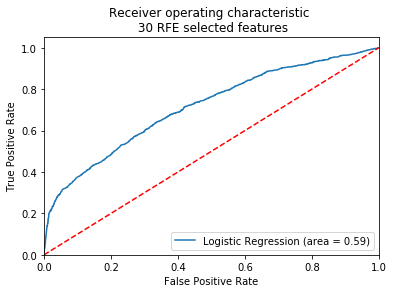

In [10]:
#4.2.2 fitting a model to the new reduced set of features

#istantiate the model
lr_rfe_50 = LogisticRegression()

#fit the model
lr_rfe_50.fit(os_X_rfe,os_y)

#using the model to predict
y_pred_lr_rfe_50 = lr_rfe_50.predict(X_test_rfe)

#-----------------------------
#model performance
# compute Receiver operating characteristic (ROC)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_lr_rfe_50)


print('accuracy sorce: ',lr_rfe_50.score(X_test_rfe,y_test))
print('auc: ',metrics.auc(fpr, tpr));

#-----------------------------
#ROC:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr_rfe_50.predict(X_test_rfe))
fpr, tpr, thresholds = roc_curve(y_test, lr_rfe_50.predict_proba(X_test_rfe)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic \n 30 RFE selected features')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [11]:
#instantiate the model
dt_rfe_50 = DecisionTreeClassifier()
#fit the model
dt_rfe_50.fit(os_X_rfe,os_y)
#prdict using the model
y_pred_dt_rfe_50 = dt_rfe_50.predict(X_test_rfe)
#checking performance
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_dt_rfe_50)

print('accuracy sorce: ',dt_rfe_50.score(X_test_rfe,y_test))
print('auc: ',metrics.auc(fpr, tpr));

accuracy sorce:  0.8851121685927941
auc:  0.5706169590863974
